In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-sentiment-analysis/data.csv


In [3]:
!pip install transformers

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Loading Data

In [4]:
data = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')
print(data.shape)
data.head()

(5842, 2)


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


<AxesSubplot:>

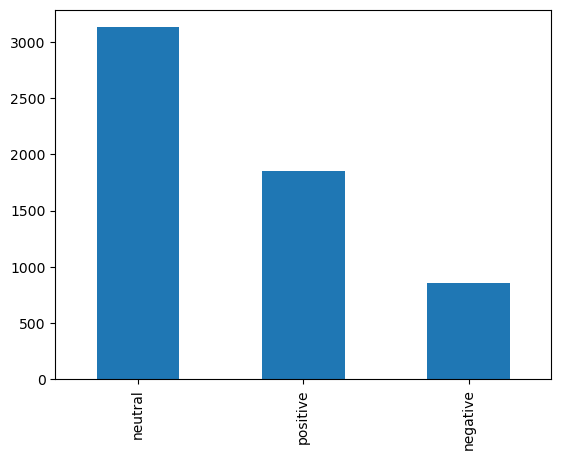

In [5]:
data['Sentiment'].value_counts().plot(kind = 'bar')

### Replacing labels with numerical values

In [6]:
data['Sentiment'].replace(['negative', 'neutral', 'positive'], 
                          [0, 1, 2], inplace=True)

### Finding max length of strings in data

In [8]:
print(data.Sentence.str.len().max())

315


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

### Downloading tokenizer and model

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3)
print(model.classifier.parameters)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<bound method Module.parameters of Linear(in_features=768, out_features=3, bias=True)>


In [11]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [12]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
model = model.to('cuda')

In [14]:
sample_data = data['Sentence'][0]
print(sample_data)

The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .


In [15]:
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

{'input_ids': [101, 1996, 20248, 19454, 13700, 2015, 2974, 2097, 21155, 3841, 12879, 2239, 1005, 1055, 14658, 7300, 2011, 4346, 3295, 2241, 3945, 2974, 1010, 1037, 4279, 4132, 1010, 3295, 7882, 14959, 4180, 1998, 1037, 2047, 1998, 3928, 3293, 2944, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Train Test Split

In [16]:
X = list(data["Sentence"])
y = list(data["Sentiment"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [17]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [19]:
print(X_train_tokenized['input_ids'][0])

[101, 3481, 2819, 2036, 2038, 1037, 10851, 8406, 1999, 7855, 1056, 2290, 2243, 1011, 1015, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
print(X_train_tokenized['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Creating torch dataset

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [22]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [23]:
train_dataset[5]

{'input_ids': tensor([  101,  1996,  3643,  1997,  1996,  3813,  1005,  1055, 13116,  9583,
          3445,  2011,  7367,  2243,  1017,  1012,  1020, 24869,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [30]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='micro')
    precision = precision_score(y_true=labels, y_pred=pred, average='micro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='micro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

### Defining Trainer

In [34]:
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=5,#20,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


### Training
using less number of epochs to save compute. Normally 10 to 20 epochs give good results

In [35]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4673
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1465
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.142700
1000,0.134000


Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1465, training_loss=0.13370328258735734, metrics={'train_runtime': 489.9753, 'train_samples_per_second': 47.686, 'train_steps_per_second': 2.99, 'total_flos': 1801067872621500.0, 'train_loss': 0.13370328258735734, 'epoch': 5.0})

### Evaluating

In [32]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1169
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 1.3211328983306885,
 'eval_accuracy': 0.7733105218135158,
 'eval_precision': 0.7733105218135158,
 'eval_recall': 0.7733105218135158,
 'eval_f1': 0.7733105218135158,
 'eval_runtime': 5.1305,
 'eval_samples_per_second': 227.854,
 'eval_steps_per_second': 14.424}

In [36]:
text = "Tesla has shown increased revenues in earning report"
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
predictions = predictions.cpu().detach().numpy()
predictions

SequenceClassifierOutput(loss=None, logits=tensor([[-2.8343, -2.9250,  8.2068]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[1.6030e-05, 1.4640e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


array([[1.6029793e-05, 1.4639594e-05, 9.9996936e-01]], dtype=float32)

### Saving model

In [37]:
trainer.save_model('CustomModel1')

Saving model checkpoint to CustomModel1
Configuration saved in CustomModel1/config.json
Model weights saved in CustomModel1/pytorch_model.bin


In [ ]:
# model_2 = BertForSequenceClassification.from_pretrained("CustomModel1")
# model_2.to('cuda')

In [ ]:
# text = "Tesla has shown increased revenues in earning report"
# inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
# outputs = model_2(**inputs)
# print(outputs)
# predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
# print(predictions)
# predictions = predictions.cpu().detach().numpy()
# predictions